In [6]:
import sys
import os

# Aggiungi il percorso del livello superiore al sys.path
sys.path.append(os.path.abspath(os.path.join('..')))

In [7]:
import src.data.make_dataset as mk

features_list = ['t0', 't1', 't2', 'a0', 'a1', 'a2', 'b0', 'b1', 'b2', 'c0', 'c1', 'c2', 'dicnotch', 'winSys', 'maxAmpl', 'sysTime', 'duration',  'Es', 'As', 'Ed', 'Ad', 'td', 'fd', 'R2_of_fit']
feature_data_path  = r"C:\Users\cical\Documents\GitHub\Repositories\tesina\data\interim\feature_extracted"

feature_df = mk.organize_data2(feature_data_path, features_list)

c:\Users\cical\Documents\GitHub\Repositories\tesina\src\data\make_dataset.py:49: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, data_df], ignore_index=True)


# Data Pre-Processing

## Split Dataset

In [8]:
X_train, X_test, y_train, y_test = mk.split_train_test(feature_df, 'Group', 0.2)

Group


## Data selection (outliers and p-value)

In [9]:
import src.data.data_selection as ds

X_train, y_train = ds.filter_outliers_by_group(X_train, y_train, features_to_ignore=['PatientID', 'SignalID', 'R2_of_fit', 'pulse_index'])

X_train, y_train = ds.filter_fit_value(X_train, y_train, 0.9, 'R2_of_fit')

Number of rows before filtering for label covid_Empoli_60: 13813
Number of rows removed for label covid_Empoli_60: 688 on 13813

Number of rows before filtering for label healthyControl_Empoli_60: 19680
Number of rows removed for label healthyControl_Empoli_60: 984 on 19680

Number of rows before filtering for label mentalDisorders_MIMIC_125: 125172
Number of rows removed for label mentalDisorders_MIMIC_125: 6259 on 125172

Number of rows before filtering for label sepsis_MIMIC_125: 95674
Number of rows removed for label sepsis_MIMIC_125: 4784 on 95674

Length before filtering: 241624
Length after filtering: 239727


## Data Trasformation

### Patient median

In [10]:
X_train, y_train = ds.calculate_patient_median(X_train, y_train, 'PatientID', features_list)
X_test, y_test = ds.calculate_patient_median(X_test, y_test, 'PatientID', features_list)

X_train.drop(columns=['PatientID',  'R2_of_fit'], inplace=True)
X_test.drop(columns=['PatientID',   'R2_of_fit'], inplace=True)

# Statistical tests

## Shapiro-Wilk test

c:\Users\cical\Documents\GitHub\Repositories\tesina\src\statistics\tests.py:16: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_df = pd.concat([result_df, pd.DataFrame([{'Feature': feature, 'Group': group, 'Statistic': stat, 'P-value': p_value}])], ignore_index=True)


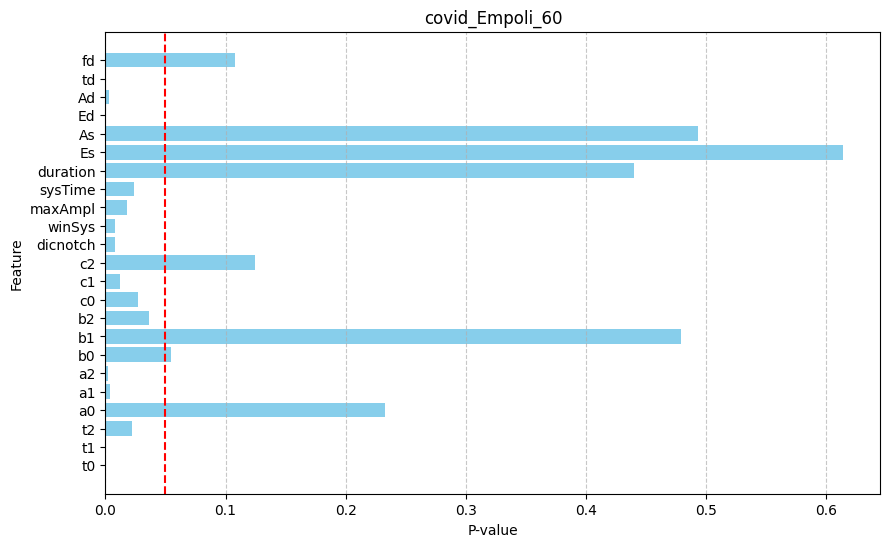

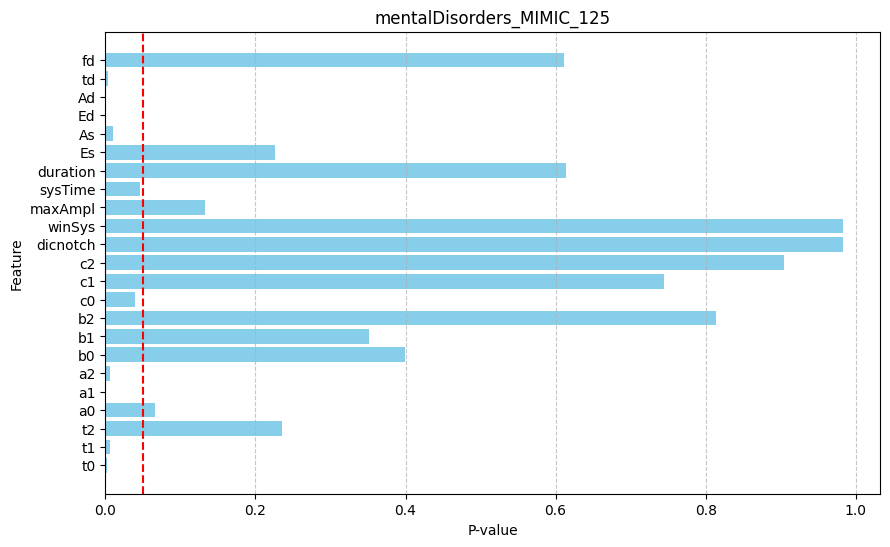

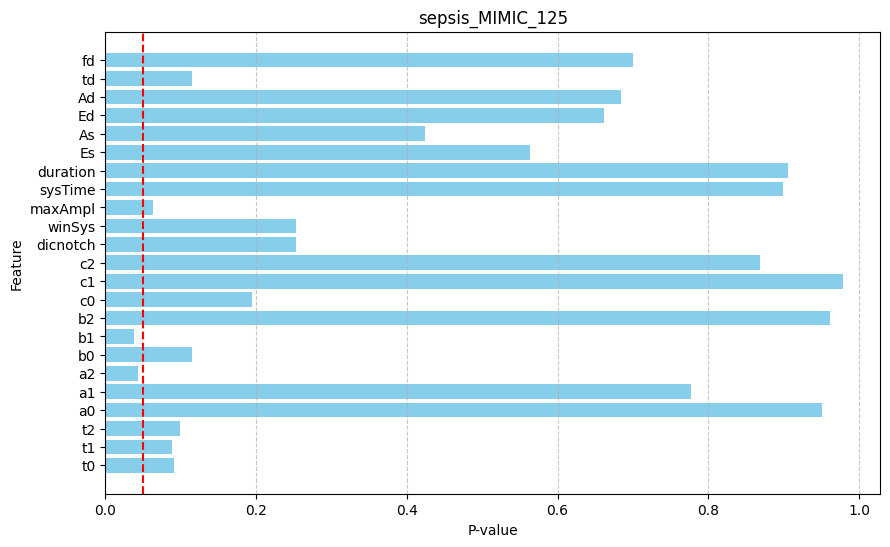

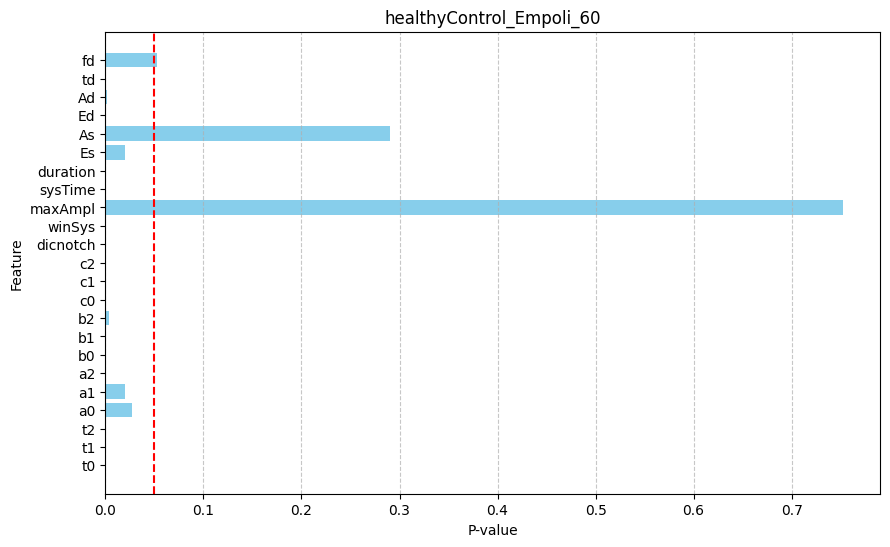

In [11]:
import src.statistics.tests as tests
import src.visualization.visualize as vis

normality_test = tests.shapiro_test(X_train, y_train)

for group in normality_test['Group'].unique():
    sub_df = normality_test[normality_test['Group'] == group]
    vis.plot_pvalues(sub_df, group)

In [12]:
import src.statistics.tests as tests

anova_test = tests.anova_test(X_train, y_train)

c:\Users\cical\Documents\GitHub\Repositories\tesina\src\statistics\tests.py:78: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_df = pd.concat([result_df, pd.DataFrame([{'Feature': feature, 'Group': group, 'Statistic': f_statistic, 'P-value': p_value}])], ignore_index=True)


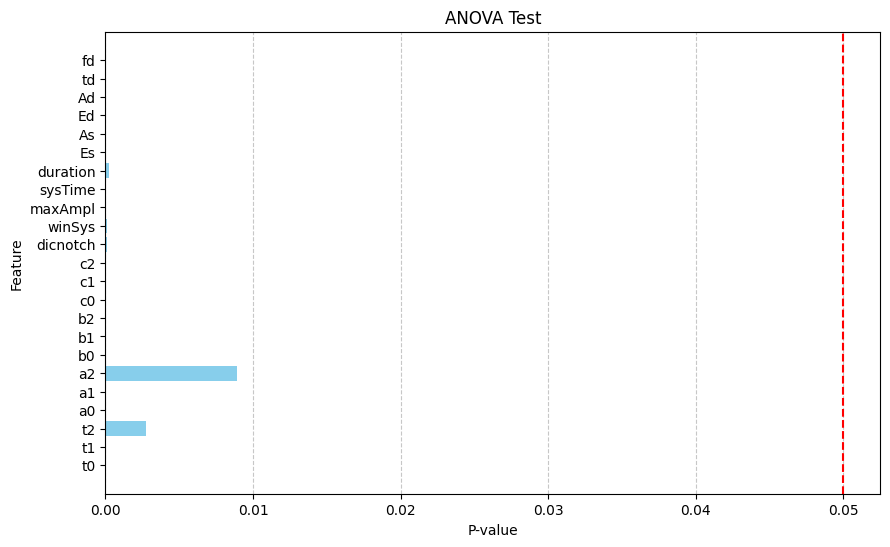

In [13]:
import src.visualization.visualize as vis

vls = vis.plot_pvalues(anova_test, 'ANOVA Test')

## Friedman test

c:\Users\cical\Documents\GitHub\Repositories\tesina\src\statistics\tests.py:59: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_df = pd.concat([result_df, pd.DataFrame([{'Feature': feature, 'Group': group, 'Statistic': f_statistic, 'P-value': p_value}])], ignore_index=True)


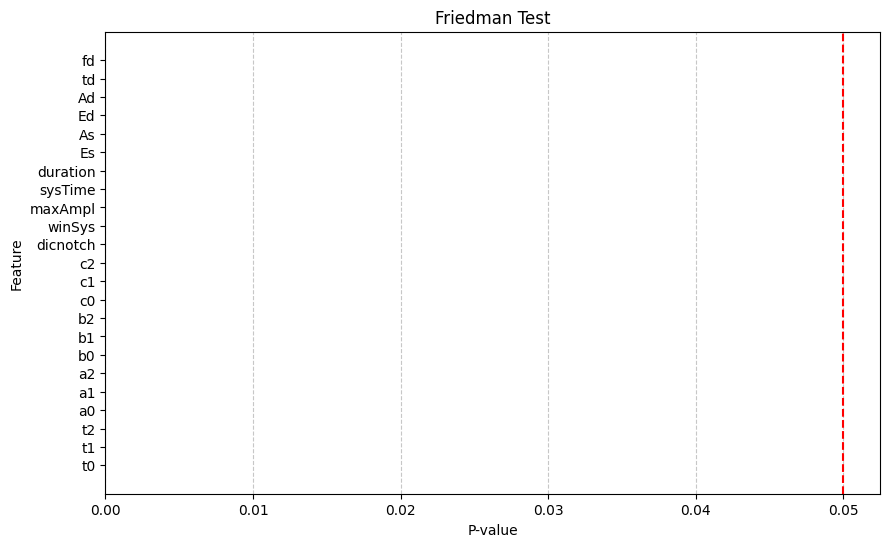

In [14]:
import src.statistics.tests as tests
import src.visualization.visualize as vis

friedman_test = tests.friedman_test(X_train, y_train)

vis.plot_pvalues(friedman_test, 'Friedman Test')


## Post-hoc Mann-Whitney U

In [15]:
import src.statistics.tests as tests

# valuto differenze tra gruppi per le features significative del test di Friedman
significant_features = friedman_test[friedman_test['P-value'] < 0.05]['Feature'].tolist()
significant_features_dict = tests.test_results_per_group_pair(X_train, y_train, significant_features=significant_features)

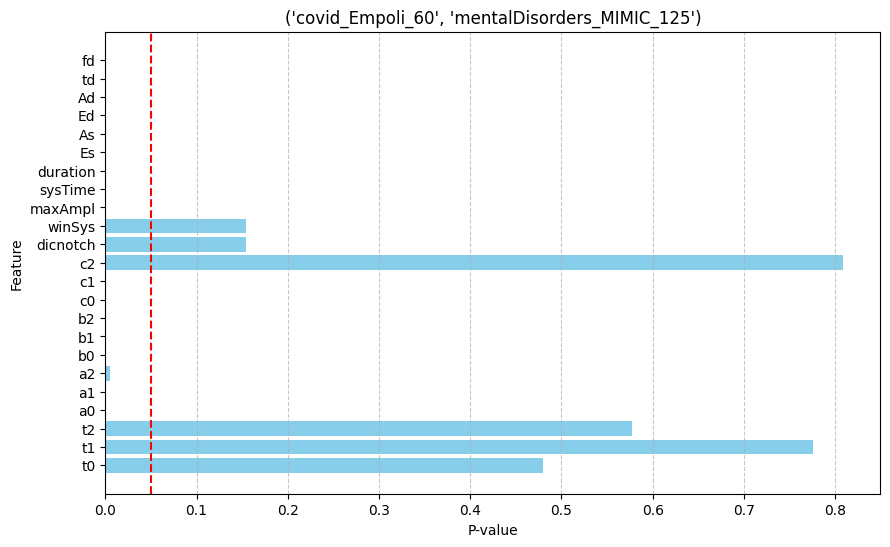

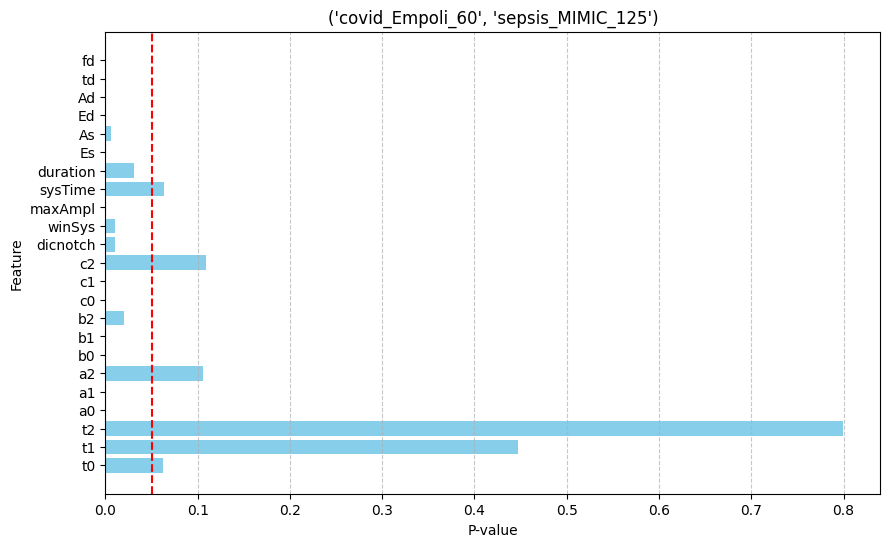

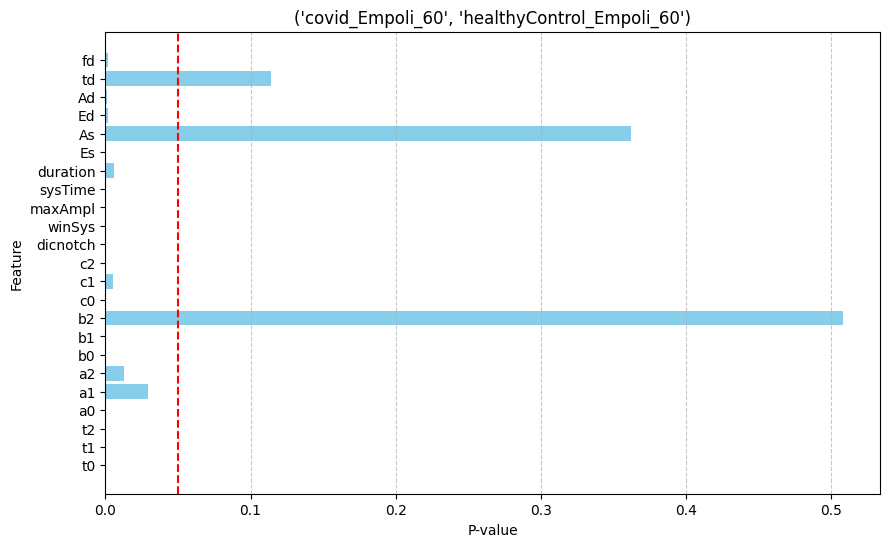

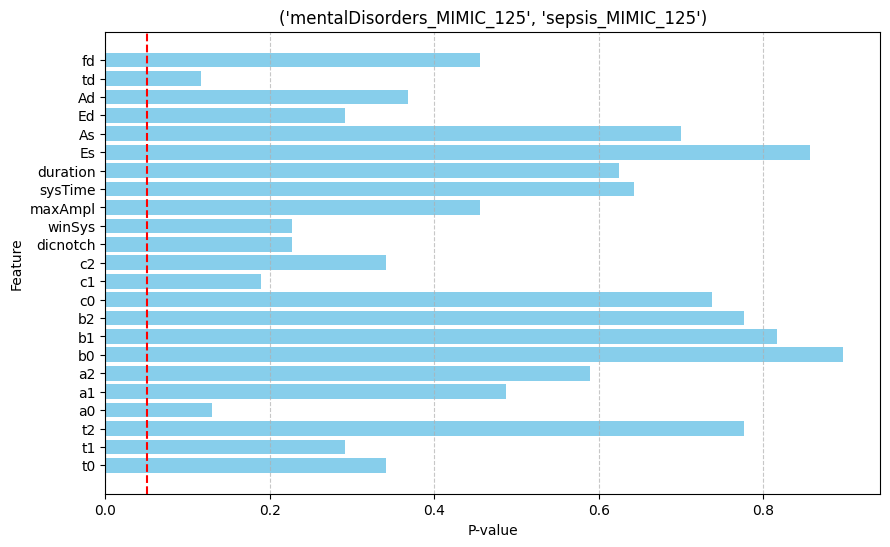

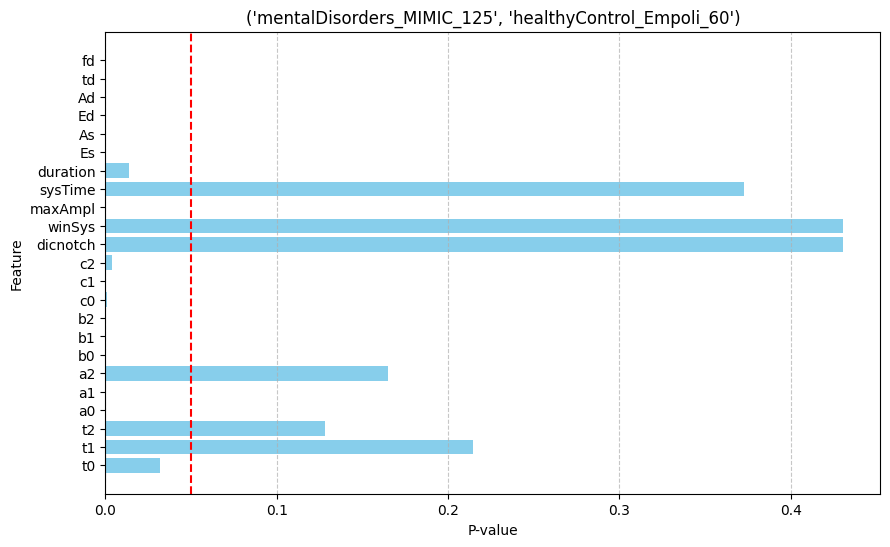

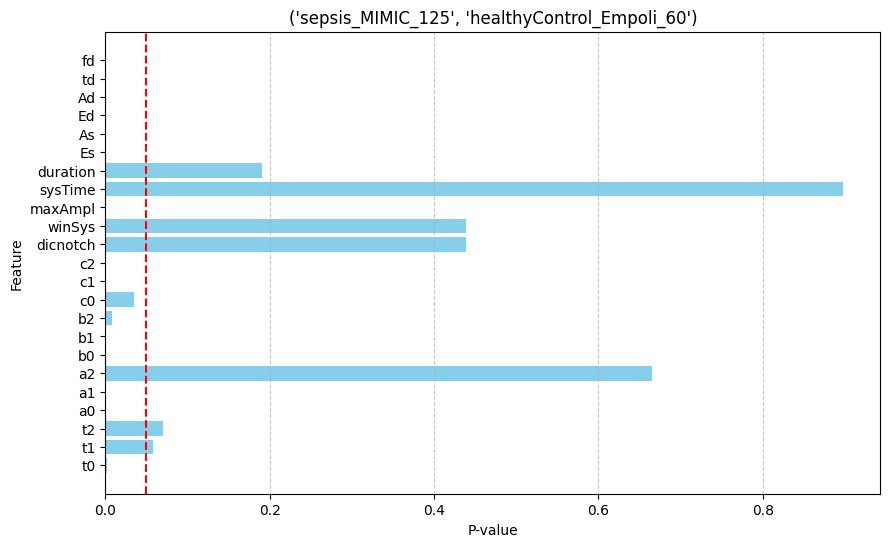

In [16]:
import src.visualization.visualize as vis

for group_pair, result in significant_features_dict.items():
    vis.plot_pvalues(result, group_pair)

## Unified dataset

c:\Users\cical\Documents\GitHub\Repositories\tesina\src\statistics\tests.py:95: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame([{'Feature': feature, 'Group': group, 'Statistic': u_statistic, 'P-value': p_value}])], ignore_index=True)


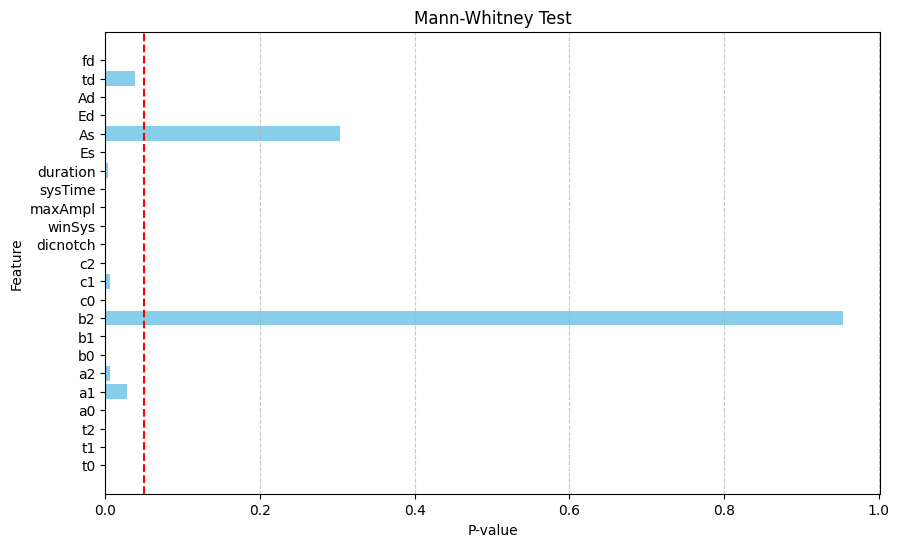

In [17]:
import src.statistics.tests as tests
import src.visualization.visualize as vis

y_train_unified = y_train.copy()

# Mappa i valori della colonna 'Group' come richiesto
mapping = {'covid_Empoli_60': "sick", 'sepsis_MIMIC_125': "sick",
           'healthyControl_Empoli_60': "healthy", 'mentalDisorders_MIMIC_125': "healthy"}
y_train_unified = y_train_unified.replace(mapping)

unified_result = tests.mann_whitney_test(X_train, y_train_unified)

vis.plot_pvalues(unified_result, 'Mann-Whitney Test')

# Training Model

## Primo test

Nel primo test si cerca di addestrare un modello che permetta di identificare tra gruppo di sani (heamth and mental disorders) e patologici (covid o sepsi). 
A questo scopo vengono utilizzate le features con un valore di p-value al di sotto della soglia impostata del test di mann-Whitney per il dataset unificato.

In [18]:
import src.data.make_dataset as mk

features_test_1 = unified_result[unified_result['P-value'] < 0.05]['Feature'].tolist()

X_train_t1 = X_train[features_test_1]
X_test_t1 = X_test[features_test_1]

y_train_t1 = y_train.map({'covid_Empoli_60': 0, 'sepsis_MIMIC_125': 0, 
                              'healthyControl_Empoli_60': 1, 'mentalDisorders_MIMIC_125': 1})

y_test_t1 = y_test.map({'covid_Empoli_60': 0, 'sepsis_MIMIC_125': 0, 
                              'healthyControl_Empoli_60': 1, 'mentalDisorders_MIMIC_125': 1})

### Cross validation

Si effettua una cross validazione con StratifiedKFold (cv=5) e si valutano le performance dei modelli per f1_macro e il coeff. di correlazioen di Matthews. I tre modelli che presentano le prestazioni migliori veranno poi migliorati con un ottizzazione degli iperparametri.

In [19]:
import src.models.cross_validation as cv

models = cv.define_models()
metric_results = cv.evaluate_models(X_train_t1, y_train_t1, models)

cv.summarize_results(metric_results)

Models Evaluation with f1_macro: 100%|██████████| 10/10 [00:10<00:00,  1.04s/it]
Models Evaluation with make_scorer(matthews_corrcoef, response_method='predict'): 100%|██████████| 10/10 [00:05<00:00,  1.98it/s]


Metric: f1_macro
Rank=1, Name=nb, Score=0.680 (+/- 0.042)
Rank=2, Name=adaboost, Score=0.680 (+/- 0.058)
Rank=3, Name=catboost, Score=0.665 (+/- 0.084)
Rank=4, Name=gbm, Score=0.657 (+/- 0.080)
Rank=5, Name=gpc, Score=0.638 (+/- 0.075)
Rank=6, Name=rf, Score=0.629 (+/- 0.054)
Rank=7, Name=svm, Score=0.613 (+/- 0.105)
Rank=8, Name=nc, Score=0.604 (+/- 0.105)
Rank=9, Name=mlp, Score=0.596 (+/- 0.131)
Rank=10, Name=dt, Score=0.577 (+/- 0.049)

Metric: make_scorer(matthews_corrcoef, response_method='predict')
Rank=1, Name=mlp, Score=0.409 (+/- 0.094)
Rank=2, Name=nb, Score=0.382 (+/- 0.076)
Rank=3, Name=adaboost, Score=0.368 (+/- 0.115)
Rank=4, Name=catboost, Score=0.358 (+/- 0.170)
Rank=5, Name=svm, Score=0.307 (+/- 0.214)
Rank=6, Name=gpc, Score=0.305 (+/- 0.148)
Rank=7, Name=gbm, Score=0.299 (+/- 0.123)
Rank=8, Name=rf, Score=0.283 (+/- 0.168)
Rank=9, Name=nc, Score=0.225 (+/- 0.205)
Rank=10, Name=dt, Score=0.206 (+/- 0.129)


In [20]:
import src.models.cross_validation as cv

cv.evaluate_optimized_models(X_train_t1, y_train_t1, model_names=['catboost', 'gbm', 'rf'], metric='f1_macro', cv=5)

Best hyperparameters for model catboost: {'iterations': 200, 'learning_rate': 0.01}
Model catboost - Score=0.666 (+/- 0.065)
---------------------------------------------------------------
Best hyperparameters for model gbm: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100}
Model gbm - Score=0.608 (+/- 0.053)
---------------------------------------------------------------
Best hyperparameters for model rf: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Model rf - Score=0.648 (+/- 0.058)
---------------------------------------------------------------


### Training and test first model

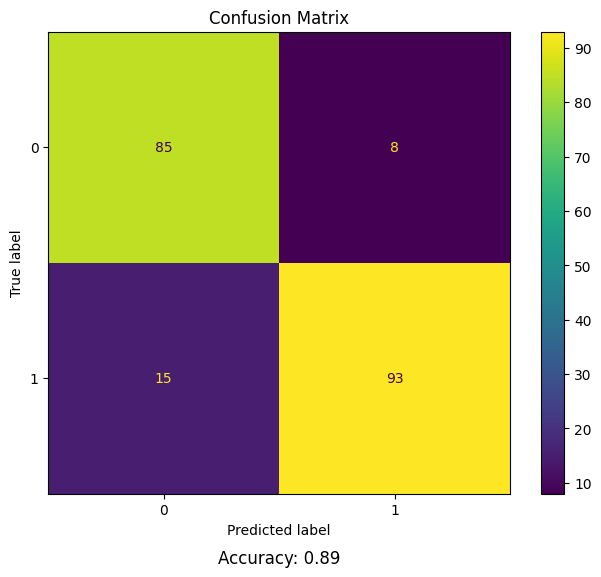

In [21]:
from sklearn.ensemble import RandomForestClassifier
import src.visualization.visualize as vis

model = RandomForestClassifier(max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100)
model.fit(X_train_t1, y_train_t1)

vis.plot_model_performance(model, X_test_t1, y_test_t1, 'accuracy')

## Secondo test (ill)

In [22]:
import src.data.make_dataset as mk

result_statistical_ill = significant_features_dict[('covid_Empoli_60', 'sepsis_MIMIC_125')]
features_test_2 = result_statistical_ill[result_statistical_ill['P-value'] < 0.05]['Feature'].tolist()

X_train_t2 = X_train[features_test_2]
X_test_t2 = X_test[features_test_2]

# si rimuovono le righe relative ai gruppi 'healthyControl_Empoli_60' e 'mentalDisorders_MIMIC_125'
target_values = ['covid_Empoli_60', 'sepsis_MIMIC_125']
X_train_t2, y_train_t2 = mk.filter_rows_by_values(X_train, y_train, target_values)
X_test_t2, y_test_t2 = mk.filter_rows_by_values(X_test, y_test, target_values)

### Cross-validation

In [23]:
import src.models.cross_validation as cv

models = cv.define_models()
metric_results = cv.evaluate_models(X_train_t2, y_train_t2, models)

cv.summarize_results(metric_results)

Models Evaluation with f1_macro: 100%|██████████| 10/10 [00:03<00:00,  2.93it/s]
Models Evaluation with make_scorer(matthews_corrcoef, response_method='predict'): 100%|██████████| 10/10 [00:03<00:00,  2.94it/s]


Metric: f1_macro
Rank=1, Name=catboost, Score=1.000 (+/- 0.000)
Rank=2, Name=dt, Score=0.944 (+/- 0.125)
Rank=3, Name=gbm, Score=0.944 (+/- 0.125)
Rank=4, Name=adaboost, Score=0.944 (+/- 0.125)
Rank=5, Name=rf, Score=0.890 (+/- 0.121)
Rank=6, Name=nb, Score=0.729 (+/- 0.239)
Rank=7, Name=nc, Score=0.680 (+/- 0.168)
Rank=8, Name=gpc, Score=0.666 (+/- 0.215)
Rank=9, Name=svm, Score=0.574 (+/- 0.239)
Rank=10, Name=mlp, Score=0.538 (+/- 0.158)

Metric: make_scorer(matthews_corrcoef, response_method='predict')
Rank=1, Name=catboost, Score=0.800 (+/- 0.447)
Rank=2, Name=dt, Score=0.709 (+/- 0.443)
Rank=3, Name=gbm, Score=0.709 (+/- 0.443)
Rank=4, Name=adaboost, Score=0.709 (+/- 0.443)
Rank=5, Name=rf, Score=0.625 (+/- 0.421)
Rank=6, Name=nb, Score=0.491 (+/- 0.464)
Rank=7, Name=nc, Score=0.474 (+/- 0.279)
Rank=8, Name=gpc, Score=0.380 (+/- 0.413)
Rank=9, Name=mlp, Score=0.184 (+/- 0.458)
Rank=10, Name=svm, Score=0.000 (+/- 0.000)


In [24]:
import src.models.cross_validation as cv

cv.evaluate_optimized_models(X_train_t2, y_train_t2, model_names=['rf', 'nb', 'catboost'], metric='f1_macro', cv=5)

Best hyperparameters for model rf: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Model rf - Score=0.821 (+/- 0.227)
---------------------------------------------------------------
Model nb does not have hyperparameters for fine tuning
Model nb - Score=0.729 (+/- 0.239)
---------------------------------------------------------------
Best hyperparameters for model catboost: {'iterations': 100, 'learning_rate': 0.1}
Model catboost - Score=1.000 (+/- 0.000)
---------------------------------------------------------------


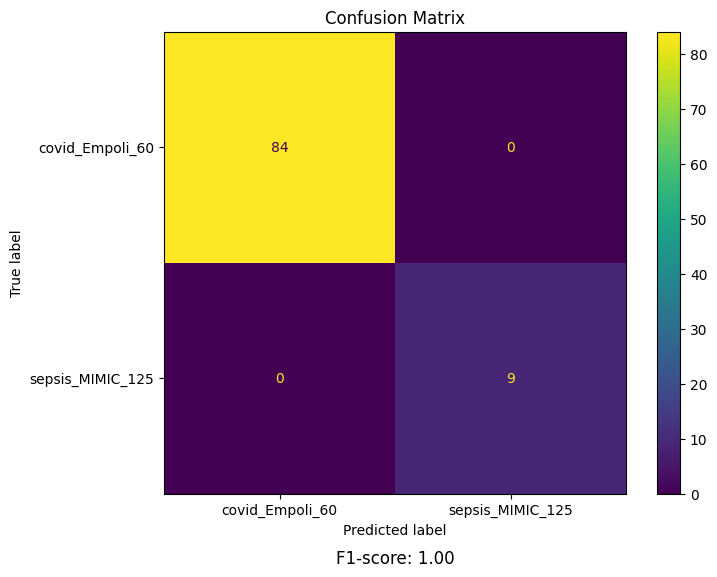

In [25]:
from sklearn.ensemble import RandomForestClassifier
import src.visualization.visualize as vis

model = RandomForestClassifier(max_depth= 10, min_samples_leaf= 4, min_samples_split=5, n_estimators=200)
model.fit(X_train_t2, y_train_t2)

vis.plot_model_performance(model, X_test_t2, y_test_t2, 'f1-score')

## Test 3 (Health)

In [26]:
import src.data.make_dataset as mk

result_statistical_health = significant_features_dict[('mentalDisorders_MIMIC_125', 'healthyControl_Empoli_60')]
features_test_3 = result_statistical_health[result_statistical_health['P-value'] < 0.05]['Feature'].tolist()

X_train_t3 = X_train[features_test_3]
X_test_t3 = X_test[features_test_3]

# si rimuovono le righe relative ai gruppi 'covid_Empoli_60' e 'sepsis_MIMIC_125'
target_values = ['mentalDisorders_MIMIC_125', 'healthyControl_Empoli_60']
X_train_t3, y_train_t3 = mk.filter_rows_by_values(X_train, y_train, target_values)
X_test_t3, y_test_t3 = mk.filter_rows_by_values(X_test, y_test, target_values)

### Cross-validation

In [27]:
import src.models.cross_validation as cv

models = cv.define_models()
metric_results = cv.evaluate_models(X_train_t3, y_test_t3, models)

cv.summarize_results(metric_results)

Models Evaluation with f1_macro: 100%|██████████| 10/10 [00:03<00:00,  2.77it/s]
Models Evaluation with make_scorer(matthews_corrcoef, response_method='predict'): 100%|██████████| 10/10 [00:03<00:00,  2.75it/s]


Metric: f1_macro
Rank=1, Name=nb, Score=0.988 (+/- 0.027)
Rank=2, Name=rf, Score=0.983 (+/- 0.038)
Rank=3, Name=catboost, Score=0.983 (+/- 0.038)
Rank=4, Name=dt, Score=0.932 (+/- 0.079)
Rank=5, Name=gbm, Score=0.927 (+/- 0.082)
Rank=6, Name=svm, Score=0.920 (+/- 0.050)
Rank=7, Name=mlp, Score=0.920 (+/- 0.050)
Rank=8, Name=gpc, Score=0.920 (+/- 0.050)
Rank=9, Name=adaboost, Score=0.910 (+/- 0.098)
Rank=10, Name=nc, Score=0.748 (+/- 0.152)

Metric: make_scorer(matthews_corrcoef, response_method='predict')
Rank=1, Name=nb, Score=0.777 (+/- 0.437)
Rank=2, Name=rf, Score=0.769 (+/- 0.435)
Rank=3, Name=catboost, Score=0.769 (+/- 0.435)
Rank=4, Name=dt, Score=0.734 (+/- 0.434)
Rank=5, Name=gbm, Score=0.711 (+/- 0.420)
Rank=6, Name=svm, Score=0.655 (+/- 0.368)
Rank=7, Name=mlp, Score=0.655 (+/- 0.368)
Rank=8, Name=gpc, Score=0.655 (+/- 0.368)
Rank=9, Name=adaboost, Score=0.634 (+/- 0.388)
Rank=10, Name=nc, Score=0.525 (+/- 0.304)


In [28]:
import src.models.cross_validation as cv

cv.evaluate_optimized_models(X_train_t3, y_train_t3, model_names=['nb', 'catboost', 'rf'], metric='f1_macro', cv=5)

Model nb does not have hyperparameters for fine tuning
Model nb - Score=0.988 (+/- 0.027)
---------------------------------------------------------------
Best hyperparameters for model catboost: {'iterations': 100, 'learning_rate': 0.1}
Model catboost - Score=0.971 (+/- 0.041)
---------------------------------------------------------------
Best hyperparameters for model rf: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Model rf - Score=0.983 (+/- 0.038)
---------------------------------------------------------------


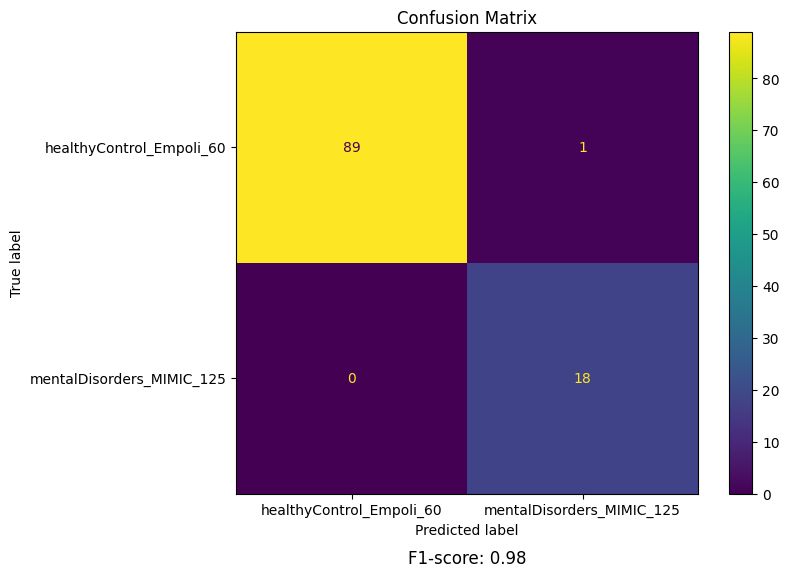

In [29]:
from sklearn.naive_bayes import GaussianNB
import src.visualization.visualize as vis

model = GaussianNB()
model.fit(X_train_t3, y_train_t3)

vis.plot_model_performance(model, X_test_t3, y_test_t3, 'f1-score')